In [1]:
# libraries to import
from linear_bandits_algorithms import *
import numpy as np

# Stochastic Linear Bandits

# Strategy 1: UCB Algorithm

The difference here is that instead of having confidence intervals, we have confidence ellipsoids.

The goal of the algorithm is to optimize the selection of actions (arms) in order to maximize the cumulative reward received over a series of rounds.

The key idea behind the algorithm is to model the relationship between the observed rewards and the features of each arm using linear regression, and then use the estimated regression coefficients to make informed decisions about which arm to select in each round.

### Steps of the algorithm



## Varying the number of items

### 10 items

In [2]:
# Setting up parameters for the runs
n_arms = 10
n_features = 10
item_features = np.random.uniform(low=-1, high=1, size=(n_features, n_arms))
true_theta = np.random.uniform(low=-1, high=1, size=(n_features, 1))

n_rounds = 1000
noise = 0.1  # 0.1 -> can lead to negative regret since the reward could be the optimal + some noise
lambda_param = 0.5

n_simulations = 50

In [3]:
# Running the algorithm
regrets_10_arms, all_theta_hat_10_arms = run_lin_ucb_average(n_simulations, n_arms, n_features, item_features, n_rounds, true_theta, noise, lambda_param)

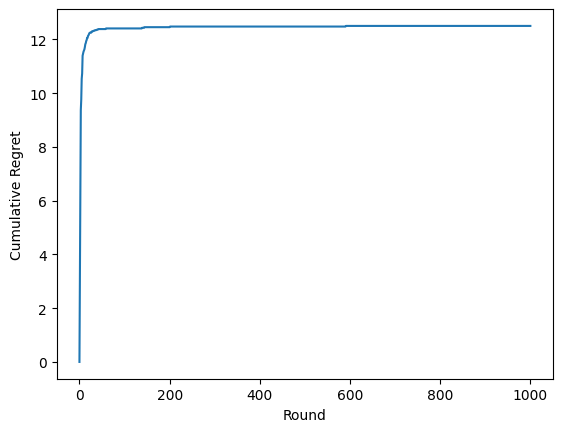

In [4]:
# Plotting the cumulative regret
plot_regret(regrets_10_arms)

In [5]:
# Calculate the difference per round
diff_per_rounds_10_arms = diff_theta_hat_true_theta(true_theta, all_theta_hat_10_arms)

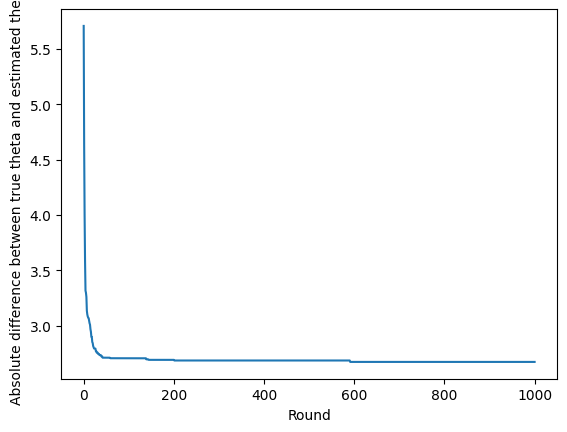

In [6]:
# Plotting the difference between the true theta and the estimate theta_hat
plot_diff_theta_hat_true_theta(diff_per_rounds_10_arms)

### 50 items

In [7]:
# Setting up parameters for the runs
n_arms = 50
n_features = 10
item_features = np.random.uniform(low=-1, high=1, size=(n_features, n_arms))
true_theta = np.random.uniform(low=-1, high=1, size=(n_features, 1))

n_rounds = 1000
noise = 0.1  # 0.1 -> can lead to negative regret since the reward could be the optimal + some noise
lambda_param = 0.5

n_simulations = 50

In [8]:
# Running the algorithm
regrets_50_arms, all_theta_hat_50_arms = run_lin_ucb_average(n_simulations, n_arms, n_features, item_features, n_rounds, true_theta, noise, lambda_param)

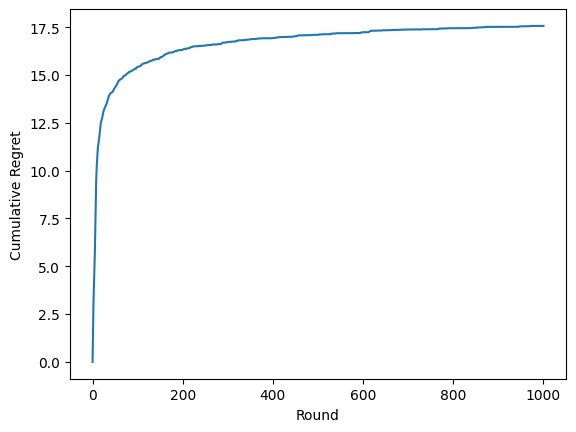

In [9]:
# Plotting the cumulative regret
plot_regret(regrets_50_arms)

In [10]:
# Calculate the difference per round
diff_per_rounds_50_arms = diff_theta_hat_true_theta(true_theta, all_theta_hat_50_arms)

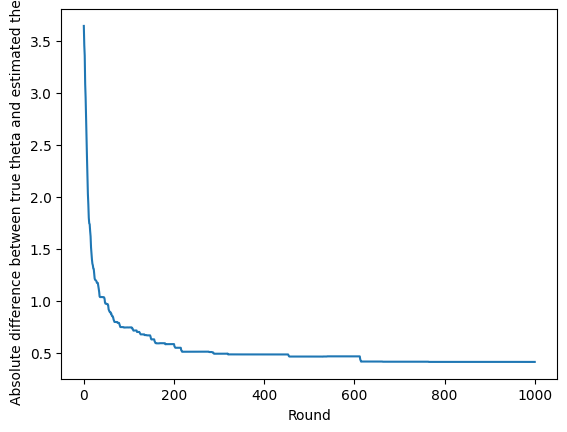

In [11]:
# Plotting the difference between the true theta and the estimate theta_hat
plot_diff_theta_hat_true_theta(diff_per_rounds_50_arms)

### 100 items

In [15]:
# Setting up parameters for the runs
n_arms = 100
n_features = 10
item_features = np.random.uniform(low=-1, high=1, size=(n_features, n_arms))
true_theta = np.random.uniform(low=-1, high=1, size=(n_features, 1))

n_rounds = 1000
noise = 0.1  # 0.1 -> can lead to negative regret since the reward could be the optimal + some noise
lambda_param = 0.5

n_simulations = 50

In [16]:
# Running the algorithm
regrets_100_arms, all_theta_hat_100_arms = run_lin_ucb_average(n_simulations, n_arms, n_features, item_features, n_rounds, true_theta, noise, lambda_param)

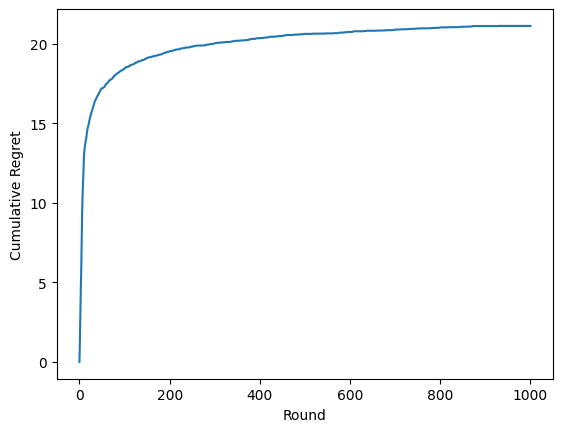

In [17]:
# Plotting the cumulative regret
plot_regret(regrets_100_arms)

In [18]:
# Calculate the difference per round
diff_per_rounds_100_arms = diff_theta_hat_true_theta(true_theta, all_theta_hat_100_arms)

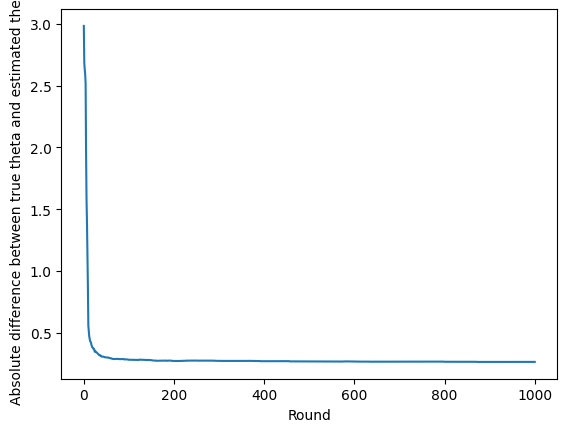

In [22]:
# Plotting the difference between the true theta and the estimate theta_hat
plot_diff_theta_hat_true_theta(diff_per_rounds_100_arms)

### Varying the number of arms

By keeping the number of features the same: 10 features, we see that as the number of arm increases, the cumulative regret converges faster (the logarithmic plot flattens out faster).

This leads to a cumulative regret being greater at step 1000 as we increase the number of arms.

This phenomenon can be explained by the fact that when there are more arms to chose, we can chose one arm that has is closest to the true feature vector theta. By increasing the number of arms, we increase the likelihood of finding arms that fits the user the best. Therefore, it is logical that we converge to an estimate faster than with less arms.

### Regret for number of arms variations

In the plot below we see the cumulative regret for different variations of the number of arms over 50 simulated rounds.

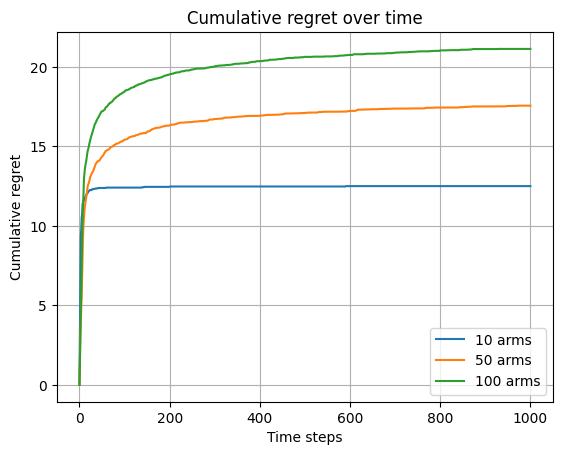

In [20]:
regrets_for_arm_variation = [regrets_10_arms, regrets_50_arms, regrets_100_arms]
labels_for_arm_variation = ["10 arms", "50 arms", "100 arms"]

# Plotting the cumulative regret for different arm
plot_cumulative_regrets(regrets_for_arm_variation, labels_for_arm_variation)

### Difference between the true theta and estimated theta for number of arms variations

In the plot below we see the difference between the true theta and estimated theta for different variations of the number of arms over 50 simulated rounds.

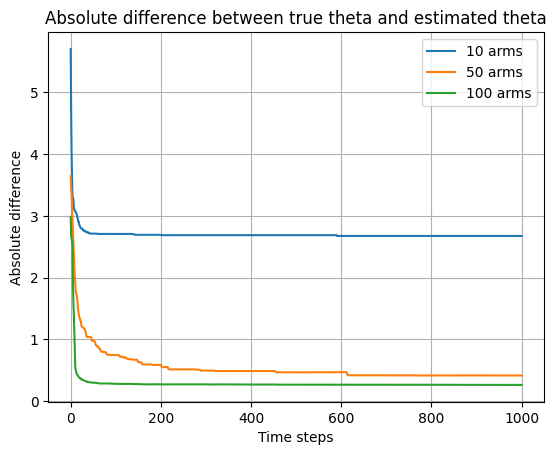

In [21]:
diff_for_arm_variation = [diff_per_rounds_10_arms, diff_per_rounds_50_arms, diff_per_rounds_100_arms]
labels_for_arm_variation = ["10 arms", "50 arms", "100 arms"]

# Plotting the difference between the true theta and the estimate theta_hat for different number of arms
plot_multiple_diff_theta_hat_true_theta(diff_for_arm_variation, labels_for_arm_variation)


## Varying the number of features

### 2 features

In [23]:
# Setting up parameters for the runs
n_arms = 100
n_features = 2
item_features = np.random.uniform(low=-1, high=1, size=(n_features, n_arms))
true_theta = np.random.uniform(low=-1, high=1, size=(n_features, 1))

n_rounds = 1000
noise = 0.1  # 0.1 -> can lead to negative regret since the reward could be the optimal + some noise
lambda_param = 0.5

n_simulations = 50

In [24]:
# Running the algorithm
regrets_2_features, all_theta_hat_2_features = run_lin_ucb_average(n_simulations, n_arms, n_features, item_features, n_rounds, true_theta, noise, lambda_param)

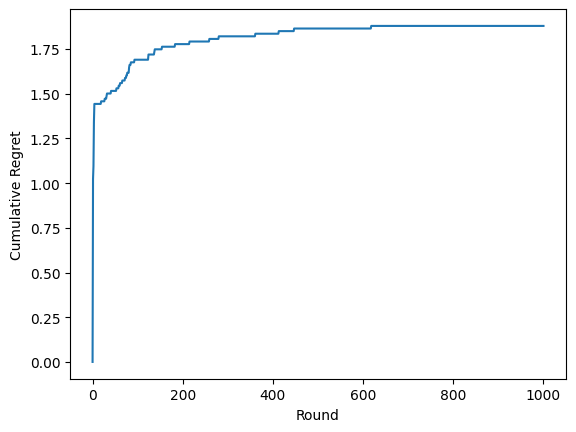

In [25]:
# Plotting the cumulative regret
plot_regret(regrets_2_features)

In [26]:
# Calculate the difference per round
diff_per_rounds_2_features = diff_theta_hat_true_theta(true_theta, all_theta_hat_2_features)

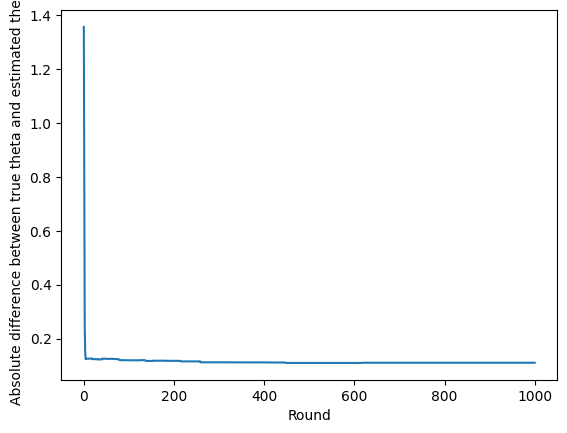

In [27]:
# Plotting the difference between the true theta and the estimate theta_hat
plot_diff_theta_hat_true_theta(diff_per_rounds_2_features)

### 10 features

In [28]:
# Setting up parameters for the runs
n_arms = 100
n_features = 10
item_features = np.random.uniform(low=-1, high=1, size=(n_features, n_arms))
true_theta = np.random.uniform(low=-1, high=1, size=(n_features, 1))

n_rounds = 1000
noise = 0.1  # 0.1 -> can lead to negative regret since the reward could be the optimal + some noise
lambda_param = 0.5

n_simulations = 50

In [29]:
# Running the algorithm
regrets_10_features, all_theta_hat_10_features = run_lin_ucb_average(n_simulations, n_arms, n_features, item_features, n_rounds, true_theta, noise, lambda_param)

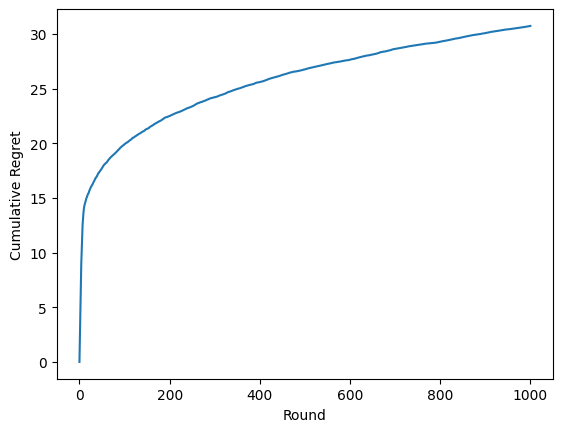

In [30]:
# Plotting the cumulative regret
plot_regret(regrets_10_features)

In [31]:
# Calculate the difference per round
diff_per_rounds_10_features = diff_theta_hat_true_theta(true_theta, all_theta_hat_10_features)

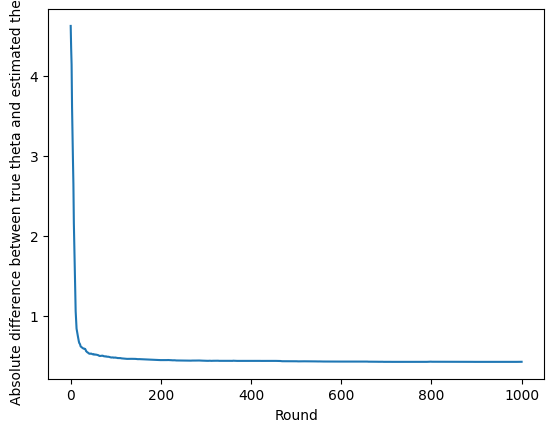

In [32]:
# Plotting the difference between the true theta and the estimate theta_hat
plot_diff_theta_hat_true_theta(diff_per_rounds_10_features)

### 50 features

In [33]:
# Setting up parameters for the runs
n_arms = 100
n_features = 50
item_features = np.random.uniform(low=-1, high=1, size=(n_features, n_arms))
true_theta = np.random.uniform(low=-1, high=1, size=(n_features, 1))

n_rounds = 1000
noise = 0.1  # 0.1 -> can lead to negative regret since the reward could be the optimal + some noise
lambda_param = 0.5

n_simulations = 50

In [34]:
# Running the algorithm
regrets_50_features, all_theta_hat_50_features = run_lin_ucb_average(n_simulations, n_arms, n_features, item_features, n_rounds, true_theta, noise, lambda_param)

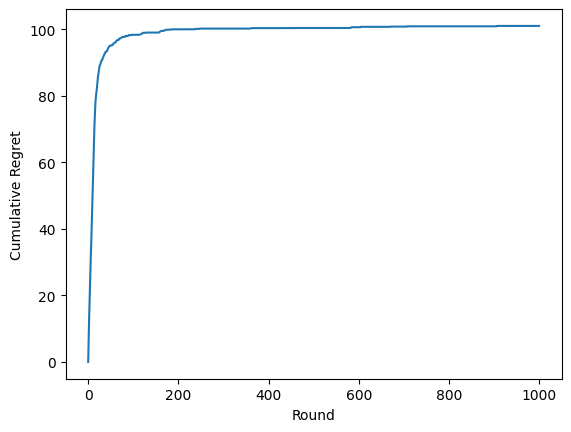

In [35]:
# Plotting the cumulative regret
plot_regret(regrets_50_features)

In [36]:
# Calculate the difference per round
diff_per_rounds_50_features = diff_theta_hat_true_theta(true_theta, all_theta_hat_50_features)

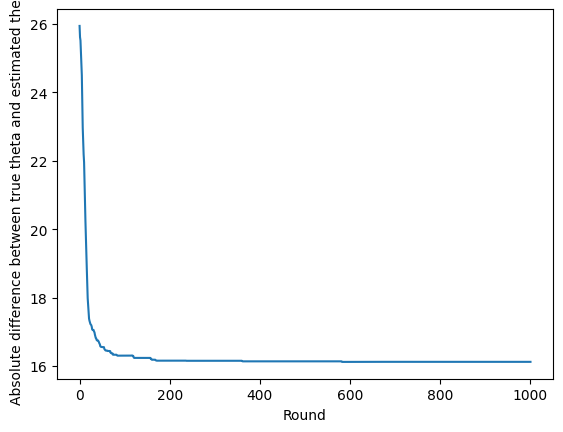

In [37]:
# Plotting the difference between the true theta and the estimate theta_hat
plot_diff_theta_hat_true_theta(diff_per_rounds_50_features)

### Varying the number of features

By keeping the number of arms the same: 100 arms

### Regret for number of features variations

In the plot below we see the cumulative regret for different variations for the number of features over 50 simulated rounds.

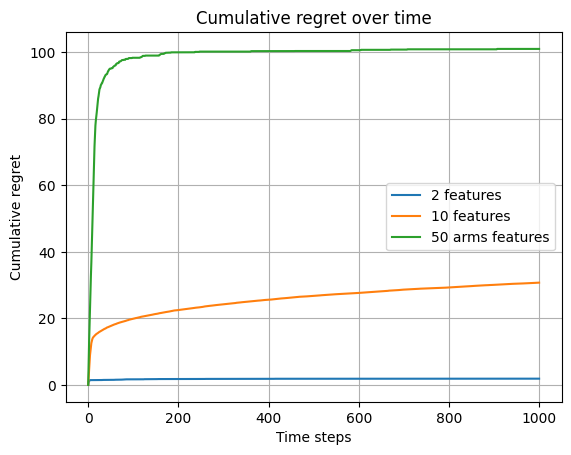

In [38]:
regrets_for_feature_variation = [regrets_2_features, regrets_10_features, regrets_50_features]
labels_for_feature_variation = ["2 features", "10 features", "50 arms features"]

# Plotting the cumulative regret for different arm
plot_cumulative_regrets(regrets_for_feature_variation, labels_for_feature_variation)

### Difference between the true theta and estimated theta for the number of features variations

In the plot below we see the difference between the true theta and estimated theta for different variations of the number of features over 50 simulated rounds.

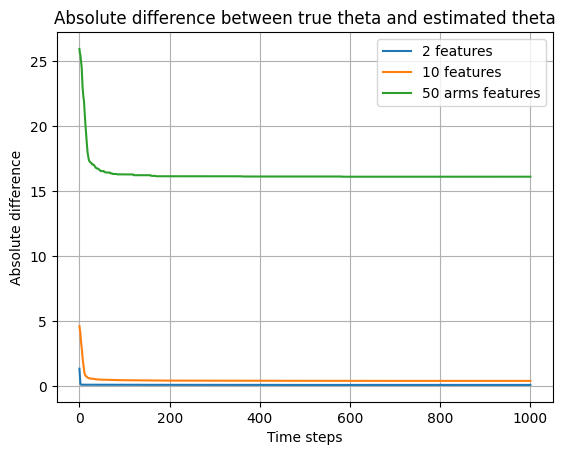

In [39]:
diff_for_feature_variation = [diff_per_rounds_2_features, diff_per_rounds_10_features, diff_per_rounds_50_features]
labels_for_feature_variation = ["2 features", "10 features", "50 arms features"]

# Plotting the difference between the true theta and the estimate theta_hat for different number of features
plot_multiple_diff_theta_hat_true_theta(diff_for_feature_variation, labels_for_feature_variation)

## Varying lambda parameter

### lambda = 0.01

In [65]:
# Setting up parameters for the runs
n_arms = 50
n_features = 10
item_features = np.random.uniform(low=-1, high=1, size=(n_features, n_arms))
true_theta = np.random.uniform(low=-1, high=1, size=(n_features, 1))

n_rounds = 1000
noise = 0.1  
lambda_param = 0.01

n_simulations = 50

In [66]:
# Running the algorithm
regrets_lambda_0_01, all_theta_hat_lambda_0_01 = run_lin_ucb_average(n_simulations, n_arms, n_features, item_features, n_rounds, true_theta, noise, lambda_param)

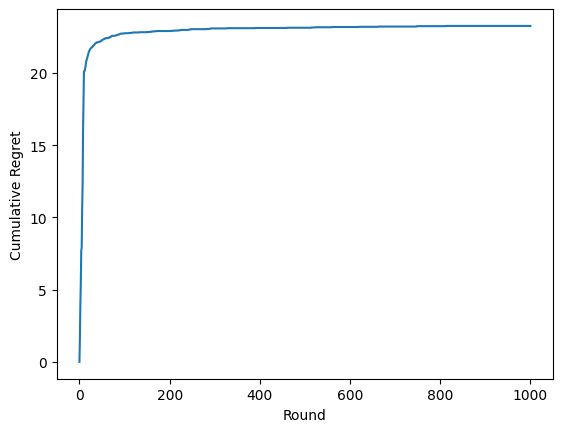

In [67]:
# Plotting the cumulative regret
plot_regret(regrets_lambda_0_01)

In [68]:
# Calculate the difference per round
diff_per_rounds_lambda_0_01 = diff_theta_hat_true_theta(true_theta, all_theta_hat_lambda_0_01)

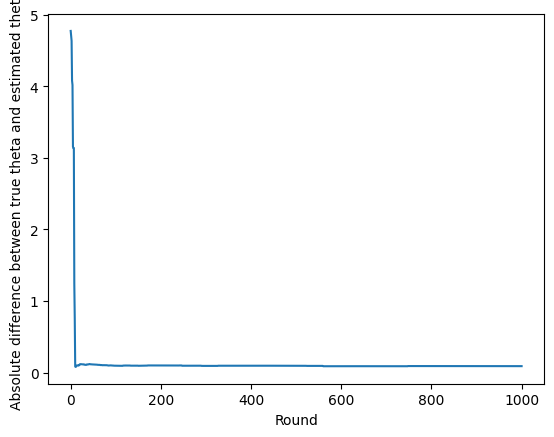

In [69]:
# Plotting the difference between the true theta and the estimate theta_hat
plot_diff_theta_hat_true_theta(diff_per_rounds_lambda_0_01)

### lambda = 0.1

In [41]:
# Setting up parameters for the runs
n_arms = 50
n_features = 10
item_features = np.random.uniform(low=-1, high=1, size=(n_features, n_arms))
true_theta = np.random.uniform(low=-1, high=1, size=(n_features, 1))

n_rounds = 1000
noise = 0.1  
lambda_param = 0.1

n_simulations = 50

In [42]:
# Running the algorithm
regrets_lambda_0_1, all_theta_hat_lambda_0_1 = run_lin_ucb_average(n_simulations, n_arms, n_features, item_features, n_rounds, true_theta, noise, lambda_param)

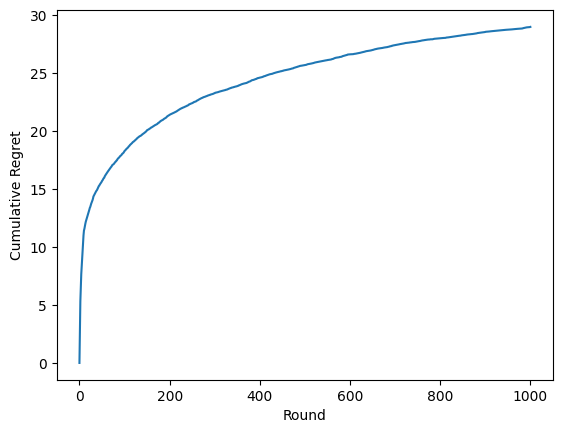

In [43]:
# Plotting the cumulative regret
plot_regret(regrets_lambda_0_1)

In [44]:
# Calculate the difference per round
diff_per_rounds_lambda_0_1 = diff_theta_hat_true_theta(true_theta, all_theta_hat_lambda_0_1)

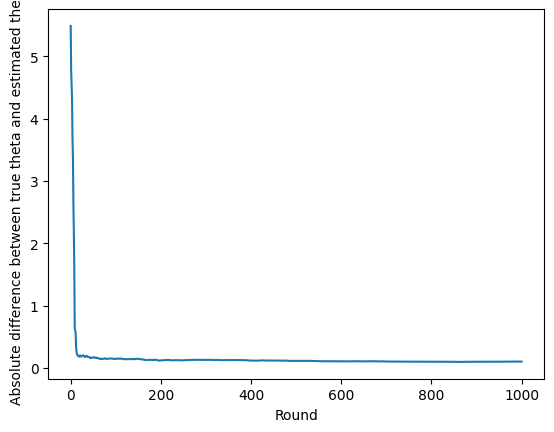

In [45]:
# Plotting the difference between the true theta and the estimate theta_hat
plot_diff_theta_hat_true_theta(diff_per_rounds_lambda_0_1)

### lambda = 0.5


In [46]:
# Setting up parameters for the runs
n_arms = 50
n_features = 10
item_features = np.random.uniform(low=-1, high=1, size=(n_features, n_arms))
true_theta = np.random.uniform(low=-1, high=1, size=(n_features, 1))

n_rounds = 1000
noise = 0.1  
lambda_param = 0.5

n_simulations = 50

In [48]:
# Running the algorithm
regrets_lambda_0_5, all_theta_hat_lambda_0_5 = run_lin_ucb_average(n_simulations, n_arms, n_features, item_features, n_rounds, true_theta, noise, lambda_param)

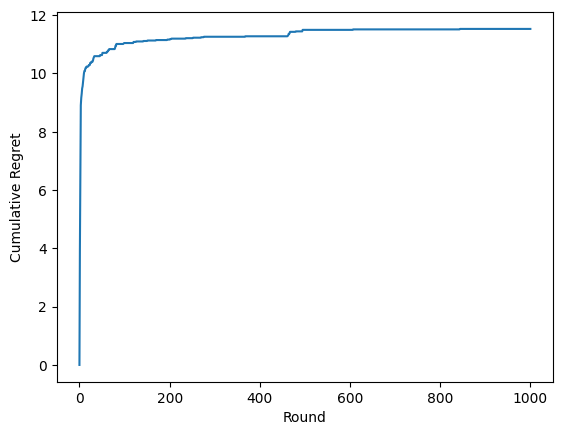

In [49]:
# Plotting the cumulative regret
plot_regret(regrets_lambda_0_5)

In [50]:
# Calculate the difference per round
diff_per_rounds_lambda_0_5 = diff_theta_hat_true_theta(true_theta, all_theta_hat_lambda_0_5)

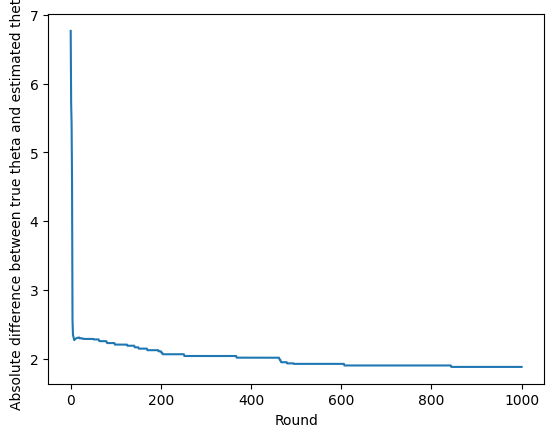

In [51]:
# Plotting the difference between the true theta and the estimate theta_hat
plot_diff_theta_hat_true_theta(diff_per_rounds_lambda_0_5)

### lambda = 1.0

In [52]:
# Setting up parameters for the runs
n_arms = 50
n_features = 10
item_features = np.random.uniform(low=-1, high=1, size=(n_features, n_arms))
true_theta = np.random.uniform(low=-1, high=1, size=(n_features, 1))

n_rounds = 1000
noise = 0.1  
lambda_param = 1.0

n_simulations = 50

In [53]:
# Running the algorithm
regrets_lambda_1, all_theta_hat_lambda_1 = run_lin_ucb_average(n_simulations, n_arms, n_features, item_features, n_rounds, true_theta, noise, lambda_param)

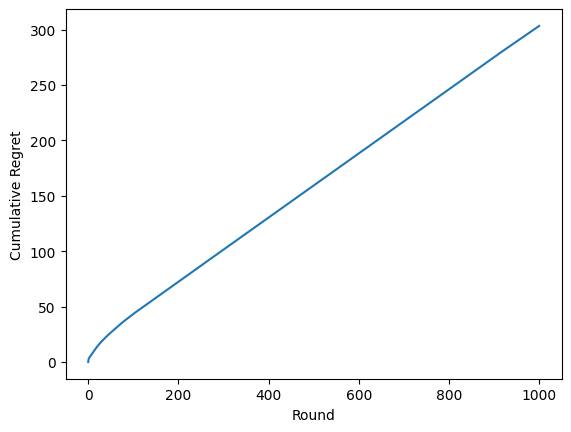

In [54]:
# Plotting the cumulative regret
plot_regret(regrets_lambda_1)

In [55]:
# Calculate the difference per round
diff_per_rounds_lambda_1 = diff_theta_hat_true_theta(true_theta, all_theta_hat_lambda_1)

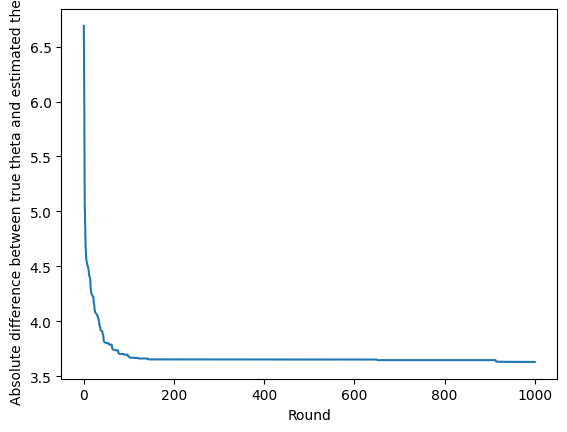

In [56]:
# Plotting the difference between the true theta and the estimate theta_hat
plot_diff_theta_hat_true_theta(diff_per_rounds_lambda_1)

### Varying the number of arms

By keeping the number of features the same: 10 features, we see that as the number of arm increases, the cumulative regret converges faster (the logarithmic plot flattens out faster).

This leads to a cumulative regret being greater at step 1000 as we increase the number of arms.

This phenomenon can be explained by the fact that when there are more arms to chose, we can chose one arm that has is closest to the true feature vector theta. By increasing the number of arms, we increase the likelihood of finding arms that fits the user the best. Therefore, it is logical that we converge to an estimate faster than with less arms.

### Regret for number of arms variations

In the plot below we see the cumulative regret for different variations of the number of arms over 50 simulated rounds.

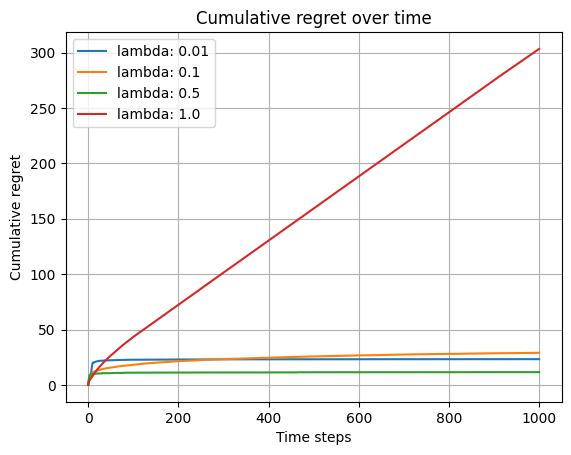

In [70]:
regrets_for_lambda_variation = [regrets_lambda_0_01, regrets_lambda_0_1, regrets_lambda_0_5, regrets_lambda_1]
labels_for_lambda_variation = ["lambda: 0.01", "lambda: 0.1", "lambda: 0.5", "lambda: 1.0"]

# Plotting the cumulative regret for different arm
plot_cumulative_regrets(regrets_for_lambda_variation, labels_for_lambda_variation)

### Difference between the true theta and estimated theta for number of arms variations

In the plot below we see the difference between the true theta and estimated theta for different variations of the number of arms over 50 simulated rounds.

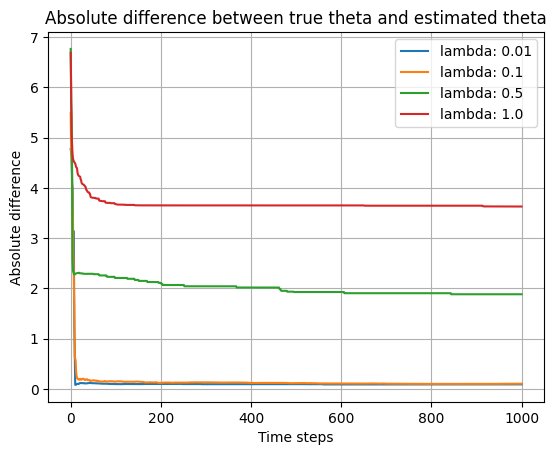

In [71]:
diff_for_lambda_variation = [diff_per_rounds_lambda_0_01, diff_per_rounds_lambda_0_1, diff_per_rounds_lambda_0_5, diff_per_rounds_lambda_1]
labels_for_lambda_variation = ["lambda: 0.01", "lambda: 0.1", "lambda: 0.5", "lambda: 1.0"]

# Plotting the difference between the true theta and the estimate theta_hat for different number of arms
plot_multiple_diff_theta_hat_true_theta(diff_for_lambda_variation, labels_for_lambda_variation)
